In [1]:
library(edgeR)
library(Seurat)
library(dplyr)

decideTests.DGEExact <- decideTests.DGELRT <- function(object,adjust.method="BH",p.value=0.05,lfc=0,...)
{
	decideTestsDGE(object=object,adjust.method=adjust.method,p.value=p.value,lfc=lfc)
}

decideTestsDGE <- function(object,adjust.method="BH",p.value=0.05,lfc=0)
#	Accept or reject hypothesis tests across genes and contrasts
#	edgeR team. Original author was Davis McCarthy.
#	Created 15 August 2010. Last modified 15 July 2018.
{
#	Check object class
	if( !(is(object,"DGEExact") || is(object,"DGELRT")) ) stop("Need DGEExact or DGELRT object")

#	Apply multiple testing
	p <- object$table$PValue
	p <- p.adjust(p, method=adjust.method)
	isDE <- as.integer(p < p.value)

#	Extract logFC
	logFC <- object$table$logFC

#	Check for F-test with multiple logFC columns
	FTest <- is.null(logFC)

#	With multiple contrasts, apply lfc threshold to maximum logFC
	if(FTest) {
		if(lfc>0) {
			coef.col <- grep("^logFC",colnames(object$table))
			logFC <- object$table[,coef.col]
			SmallFC <- rowSums(abs(logFC) >= lfc) == 0
			isDE[SmallFC] <- 0L
		}

#	With single contrast, apply directionality and lfc threshold
	} else {
		isDE[isDE & logFC<0] <- -1L
		SmallFC <- (abs(logFC) < lfc)
		isDE[SmallFC] <- 0L
	}

#	Assemble TestResults object
	isDE <- matrix(isDE, ncol=1)
	row.names(isDE) <- row.names(object)
	colnames(isDE) <- paste(rev(object$comparison),collapse="-")

#	Record possible values
	if(FTest) {
		attr(isDE,"levels") <- c(0L,1L)
		attr(isDE,"labels") <- c("NotSig","Sig")
	} else {
		attr(isDE,"levels") <- c(-1L,0L,1L)
		attr(isDE,"labels") <- c("Down","NotSig","Up")
	}		

	new("TestResults", isDE)
}

Loading required package: limma

Warning message:
“package ‘Seurat’ was built under R version 4.4.1”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.4.1”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.4.1”
‘SeuratObject’ was built with package ‘Matrix’ 1.6.5 but the current
version is 1.7.1; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Warning message:
“package ‘dplyr’ was built under R version 4.4.1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
A #control
B #control
C #drug
D #drug

In [2]:
setwd("Fig6/")

# new

In [ ]:
# File paths
files <- c("/QRISdata/Q4386/polyA_FreshFrozen/brain_tuan/renamed/A_uTARs_final_mat.txt",
           "/QRISdata/Q4386/polyA_FreshFrozen/brain_tuan/renamed/B_uTARs_final_mat.txt",
           "/QRISdata/Q4386/polyA_FreshFrozen/brain_tuan/renamed/C_uTARs_final_mat.txt", 
           "/QRISdata/Q4386/polyA_FreshFrozen/brain_tuan/renamed/D_uTARs_final_mat.txt")
suffixes <- c("_A", "_B", "_C", "_D")

# Read files and rename columns
count_list <- lapply(seq_along(files), function(i) {
  df <- read.table(files[i], header = TRUE, row.names = 1, sep = "\t", check.names = FALSE)
  colnames(df) <- paste0(colnames(df), suffixes[i])
  return(df)
})

# (Optional) Combine into one big matrix if all genes are the same
combined_counts <- do.call(cbind, count_list)


In [71]:
A <- read.table("/QRISdata/Q4386/polyA_FreshFrozen/brain_tuan/renamed/A_uTARs_final_mat.txt", header = TRUE, row.names = 1, sep = "\t", check.names = FALSE)
colnames(A) <- paste0(colnames(A), "_A")

B <- read.table("/QRISdata/Q4386/polyA_FreshFrozen/brain_tuan/renamed/B_uTARs_final_mat.txt", header = TRUE, row.names = 1, sep = "\t", check.names = FALSE)
colnames(B) <- paste0(colnames(B), "_B")

C <- read.table("/QRISdata/Q4386/polyA_FreshFrozen/brain_tuan/renamed/C_uTARs_final_mat.txt", header = TRUE, row.names = 1, sep = "\t", check.names = FALSE)
colnames(C) <- paste0(colnames(C), "_C")

D <- read.table("/QRISdata/Q4386/polyA_FreshFrozen/brain_tuan/renamed/D_uTARs_final_mat.txt", header = TRUE, row.names = 1, sep = "\t", check.names = FALSE)
colnames(D) <- paste0(colnames(D), "_D")


In [72]:
dim(A)
dim(B)

[1] 7339 4134

[1] 6383 3504

In [81]:
# Find common rownames across all four data frames
common_rows <- Reduce(intersect, list(rownames(A), rownames(B), rownames(C), rownames(D)))

# Subset each data frame to only include the common rows
A_sub <- A[common_rows, , drop = FALSE]
B_sub <- B[common_rows, , drop = FALSE]
C_sub <- C[common_rows, , drop = FALSE]
D_sub <- D[common_rows, , drop = FALSE]

# Merge the subsetted data frames by row names (they're already aligned)
merged_df_common <- cbind(A_sub, B_sub, C_sub, D_sub)


In [82]:
# Get the union of all rownames
all_rows <- Reduce(union, list(rownames(A), rownames(B), rownames(C), rownames(D)))

# Function to pad a data frame with missing rows filled with 0
pad_df <- function(df, all_rows) {
  missing <- setdiff(all_rows, rownames(df))
  if (length(missing) > 0) {
    pad <- matrix(0, nrow = length(missing), ncol = ncol(df))
    rownames(pad) <- missing
    colnames(pad) <- colnames(df)
    df <- rbind(df, pad)
  }
  # Reorder to match all_rows
  df[all_rows, , drop = FALSE]
}

# Pad all data frames
A_pad <- pad_df(A, all_rows)
B_pad <- pad_df(B, all_rows)
C_pad <- pad_df(C, all_rows)
D_pad <- pad_df(D, all_rows)

# Merge
merged_df <- cbind(A_pad, B_pad, C_pad, D_pad)


In [83]:
grep("cuTAR290541",rownames(merged_df))

[1] 3436

In [84]:
so<-CreateSeuratObject(merged_df)
so

Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


An object of class Seurat 
15237 features across 14982 samples within 1 assay 
Active assay: RNA (15237 features, 0 variable features)
 1 layer present: counts

# old

In [3]:
so_old<-readRDS("raw_combined_seurat.rds")
so_old <- subset(so_old, subset = condition %in% c("NoDrug_Tumor", "Drug_Tumor"))

set.seed(123)  # for reproducibility

# Create a new 'cluster' column
so_old$cluster <- NA

# Loop through each sample and assign random clusters
samples <- unique(so_old$sample)
for (s in samples) {
  cell_ids <- WhichCells(so_old, expression = sample == s)
  so_old$cluster[cell_ids] <- sample(1:2, length(cell_ids), replace = TRUE)
}


head(so_old)

,orig.ident,nCount_RNA,nFeature_RNA,sample,condition,drug,cluster
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>
AAACAGAGCGACTCCT.1_A,Brain_PDOX,60,54,A,NoDrug_Tumor,NoDrug,1
AAACAGGGTCTATATT.1_A,Brain_PDOX,13,13,A,NoDrug_Tumor,NoDrug,2
AAACCCGAACGAAATC.1_A,Brain_PDOX,15,14,A,NoDrug_Tumor,NoDrug,1
AAACCGGGTAGGTACC.1_A,Brain_PDOX,29,26,A,NoDrug_Tumor,NoDrug,1
AAACCTCATGAAGTTG.1_A,Brain_PDOX,17,16,A,NoDrug_Tumor,NoDrug,2
AAACGAGACGGTTGAT.1_A,Brain_PDOX,26,24,A,NoDrug_Tumor,NoDrug,1
AAACGTGTTCGCCCTA.1_A,Brain_PDOX,31,29,A,NoDrug_Tumor,NoDrug,1
AAACTCGTGATATAAG.1_A,Brain_PDOX,31,29,A,NoDrug_Tumor,NoDrug,1
AAACTGCTGGCTCCAA.1_A,Brain_PDOX,26,24,A,NoDrug_Tumor,NoDrug,2


In [4]:
so_old@meta.data %>% group_by(condition, cluster) %>% tally()

condition,cluster,n
<chr>,<int>,<int>
Drug_Tumor,1,1018
Drug_Tumor,2,1025
NoDrug_Tumor,1,2078
NoDrug_Tumor,2,2107


In [179]:
y<-Seurat2PB(so_old,sample="cluster",cluster="condition")
summary(y$samples$lib.size)

keep.samples<-y$samples$lib.size > 100 
#table(keep.samples) 

y<-y[,keep.samples]
#Keep only uTARs for DE analysis. Skip to calculate FC for gene-co-exp
#uTARs <- rownames(y)[grep("^uTAR", rownames(y))]
#y<-y[uTARs,,keep=FALSE]

#normalization
y<-normLibSizes(y)

#MDS plots
cluster<-as.factor(y$samples$cluster) 
pdf("MDS_uTAR.pdf")
plotMDS(y,pch=16,col=c(2:8)[cluster],main="MDS") 
legend("topleft",legend=paste0(levels(cluster)), pch=14,col=2:8,cex=0.8)
dev.off()

#design matrix
donor<-factor(y$sample$sample)
design<-model.matrix(~cluster+donor)
colnames(design)<-gsub("donor","",colnames(design))
colnames(design)<-gsub("cluster","",colnames(design))
colnames(design)[1]<-"Int"

#dispersion estimates
#Dispersion Estimation
y<-estimateDisp(y,design,robust=TRUE)
y$common.dispersion #0.14  #0.2852. #V3 0.05g
pdf("dispersion.pdf")
plotBCV(y)
dev.off()

fit<-glmQLFit(y,design,robust=TRUE) 
pdf("QLdisp.pdf")
plotQLDisp(fit)
dev.off()


## Marker gene identification
ncls<-nlevels(cluster) 
contr<-rbind(matrix(1/(1-ncls),ncls,ncls), +matrix(0,ncol(design)-ncls,ncls)) 
diag(contr)<-1 
contr[1,]<-0 
rownames(contr)<-colnames(design) 
colnames(contr)<-levels(cluster)
contr

# Qasi-likelihood f-test for each comprison
qlf<-list() 
for(i in 1:ncls){ 
  qlf[[i]]<-glmQLFTest(fit,contrast=contr[,i]) 
  qlf[[i]]$comparison<-paste0(levels(donor)[i],"_vs_others") 
}

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19489   19835   35002   34936   50103   50248 

pdf 
  2

[1] 0.002188276

pdf 
  2

pdf 
  2

,Drug_Tumor,NoDrug_Tumor
Int,0,0
NoDrug_Tumor,-1,1
2,0,0


In [134]:
str(qlf)

List of 2
 $ :Formal class 'DGELRT' [package "edgeR"] with 1 slot
  .. ..@ .Data:List of 26
  .. .. ..$ : num [1:15237, 1:3] -12.51 -13.6 -11.65 -7.48 -12.26 ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:15237] "cuTAR100000" "cuTAR10001" "cuTAR100102" "cuTAR100103" ...
  .. .. .. .. ..$ : chr [1:3] "Int" "NoDrug_Tumor" "2"
  .. .. ..$ : num [1:15237, 1:4] 5.80e-08 2.81e-14 1.51e-07 1.28e+01 1.67e-07 ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:15237] "cuTAR100000" "cuTAR10001" "cuTAR100102" "cuTAR100103" ...
  .. .. .. .. ..$ : chr [1:4] "1_clusterDrug_Tumor" "1_clusterNoDrug_Tumor" "2_clusterDrug_Tumor" "2_clusterNoDrug_Tumor"
  .. .. ..$ : num [1:15237] 2.63e-07 5.61e-07 4.96e-07 3.17e-01 4.02e-07 ...
  .. .. ..$ : int [1:15237] 16 15 16 4 15 4 4 4 0 3 ...
  .. .. ..$ : logi [1:15237] FALSE FALSE FALSE FALSE FALSE FALSE ...
  .. .. ..$ : chr "levenberg"
  .. .. ..$ : num [1:15237, 1:3] -26.7 -41.24 -25.75 -7.49 -25.64 ...
 

In [181]:
top <- 25  # Number of top genes to select from each direction (up and down)
topMarkers <- list()

for (i in 1:ncls) {
  # Get the table for the current cluster
  qlf[[i]]$table$FDR <- p.adjust(qlf[[i]]$table$PValue, method = "BH")
  current_table <- qlf[[i]]$table

  # Order genes by PValue, then by logFC (positive and negative separately)
  ordered_genes <- current_table[order(current_table$PValue, decreasing = FALSE), ]
  ordered_genes <- ordered_genes[ordered_genes$FDR < 0.05, ]

  # Filter for upregulated genes (logFC > 0)
  upregulated <- ordered_genes[ordered_genes$logFC > 2, ]
  upregulated <- upregulated[order(-upregulated$logFC), ]  # Sort by descending logFC
  
  # Filter for downregulated genes (logFC < 0)
  downregulated <- ordered_genes[ordered_genes$logFC < 2, ]
  downregulated <- downregulated[order(downregulated$logFC), ]  # Sort by ascending logFC
  
  # Remove unwanted genes (e.g., RPS, RPL, LINC)
  upregulated <- upregulated[!grepl("^RPS|^RPL|^LINC", rownames(upregulated)), ]
  downregulated <- downregulated[!grepl("^RPS|^RPL|^LINC", rownames(downregulated)), ]
  
  # Select top N genes from both up and down
  top_up <- head(rownames(upregulated), top)
  top_down <- head(rownames(downregulated), top)
  
  # Combine selected genes for this cluster
  topMarkers[[i]] <- c(top_up, top_down)
}

# Combine all selected genes into a single list
combined_topMarkers <- unlist(topMarkers, use.names = FALSE)

# Remove duplicates if necessary
combined_topMarkers <- unique(combined_topMarkers)

# Print the total number of genes in the final list
length(combined_topMarkers)

# Final result: `combined_topMarkers` contains top genes (upregulated and downregulated) for all clusters
topMarkers <-combined_topMarkers

[1] 50

In [182]:
grep("cuTAR290541",rownames(qlf[[2]]$table))

[1] 6536

In [183]:

qlf[[2]]$table[6536,]

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cuTAR290541,2.262392,9.259154,21.27909,4.031101e-06,0.000491375


In [187]:
lcpm<-cpm(y,log=TRUE) 
annot<-data.frame(cluster=cluster) 
rownames(annot)<-colnames(y) 
ann_colors<-list(cluster=0:5) 
names(ann_colors$cluster)<-levels(cluster)

In [185]:
colnames(lcpm)

[1] "1_clusterDrug_Tumor"   "1_clusterNoDrug_Tumor" "2_clusterDrug_Tumor"  
[4] "2_clusterNoDrug_Tumor"

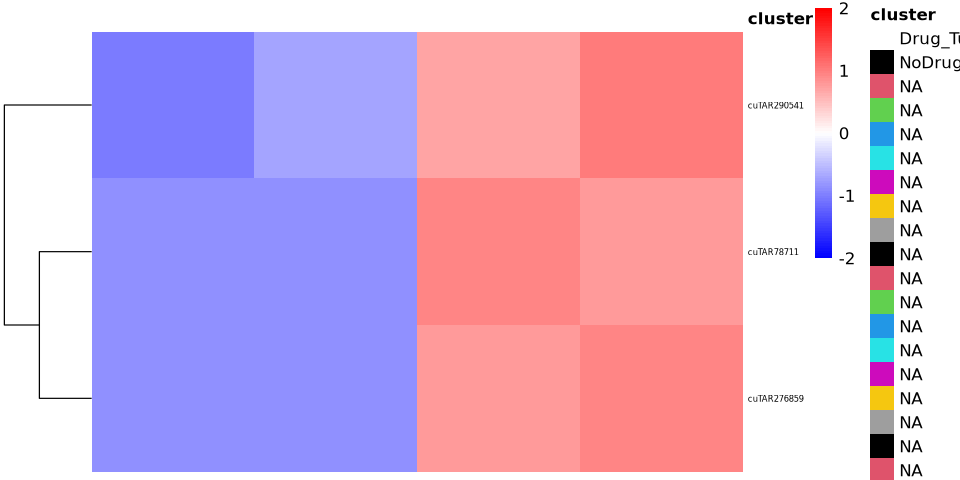

In [130]:
desired_order<-c("1_clusterDrug_Tumor","2_clusterDrug_Tumor","1_clusterNoDrug_Tumor","2_clusterNoDrug_Tumor")
lcpm_o <- lcpm[,match(desired_order, colnames(lcpm)), drop = FALSE]


rownames(annot)<-gsub("cluster","",rownames(annot))
annot_o <- annot[match(desired_order, rownames(annot)), , drop = FALSE]



options(repr.plot.width = 8, repr.plot.height = 4)

pheatmap::pheatmap(lcpm_o[c("cuTAR78711","cuTAR276859","cuTAR290541"),],breaks=seq(-2,2,length.out=101),color=colorRampPalette(c("blue","white","red"))(100),scale="row",
                   cluster_cols=FALSE,border_color="NA",fontsize_row=5,
                   show_colnames=FALSE,
                   annotation_col=annot_o,annotation_colors=ann_colors)
#grid.text(levels(annot_o$cluster), x = c(0.25, 0.6), y = c(0.89, 0.89),gp = gpa

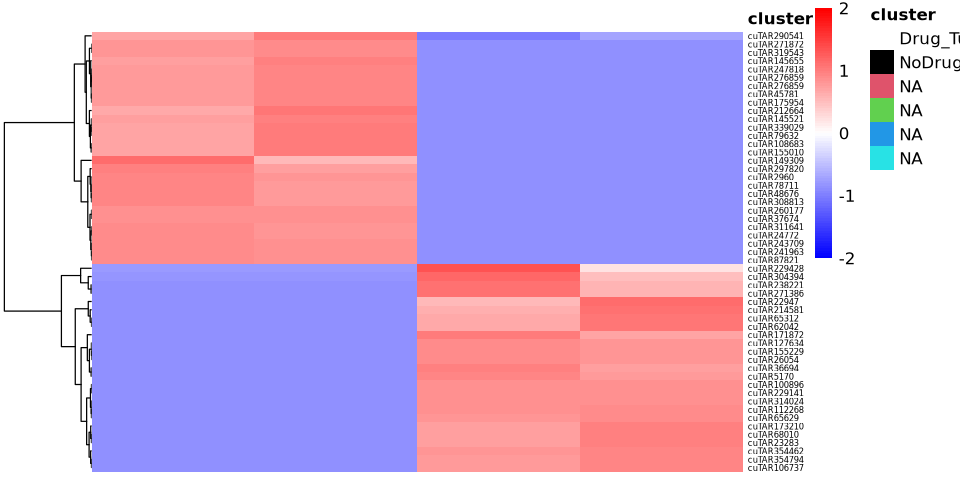

In [189]:
desired_order<-c("1_clusterNoDrug_Tumor","2_clusterNoDrug_Tumor","1_clusterDrug_Tumor","2_clusterDrug_Tumor")
lcpm_o <- lcpm[,match(desired_order, colnames(lcpm)), drop = FALSE]


rownames(annot)<-gsub("cluster","",rownames(annot))
annot_o <- annot[match(desired_order, rownames(annot)), , drop = FALSE]



options(repr.plot.width = 8, repr.plot.height = 4)

pheatmap::pheatmap(lcpm_o[c(topMarkers,"cuTAR78711","cuTAR276859","cuTAR290541"),],breaks=seq(-2,2,length.out=101),color=colorRampPalette(c("blue","white","red"))(100),scale="row",
                   cluster_cols=FALSE,border_color="NA",fontsize_row=5,
                   show_colnames=FALSE,
                   annotation_col=annot_o,annotation_colors=ann_colors)
#grid.text(levels(annot_o$cluster), x = c(0.25, 0.6), y = c(0.89, 0.89),gp = gpa

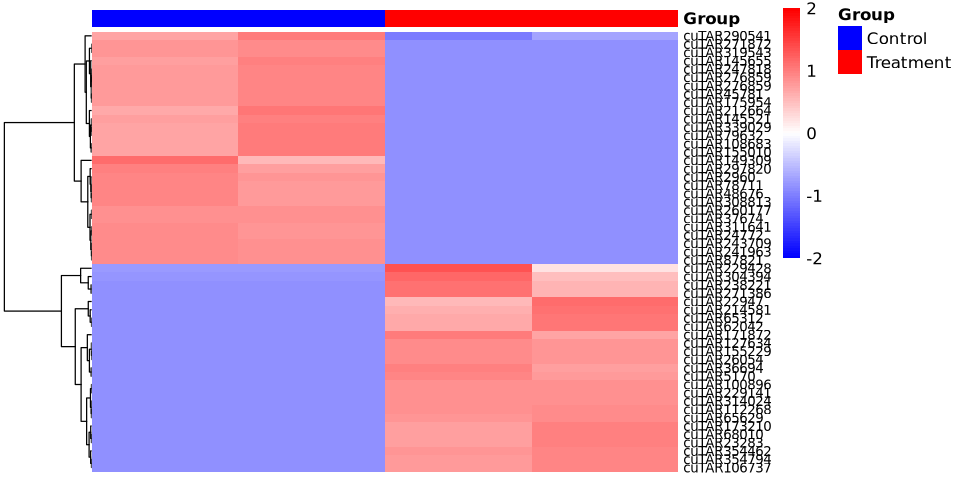

In [192]:
heatmap_data2 <- lcpm_o[c(topMarkers,"cuTAR78711","cuTAR276859","cuTAR290541"), ]

# Create a column annotation (for KM1 and KM2)
annotation_col <- data.frame(
  Group = rep(c("Control", "Treatment"), each = 2)  # Adjust according to your number of columns per group
)

# Set rownames of the annotation to match column names in the heatmap
rownames(annotation_col) <- colnames(heatmap_data2)

pheatmap::pheatmap(
  heatmap_data2,
  breaks = seq(-2, 2, length.out = 101),
  color = colorRampPalette(c("blue", "white", "red"))(100),
  scale = "row",
  cluster_cols = FALSE,
  border_color = "NA",
  fontsize_row = 8,
  show_colnames = FALSE,
  annotation_col = annotation_col,  # Adding the annotation column here
  annotation_colors = list(Group = c("Control" = "blue", "Treatment" = "red"))  # Customize colors for annotation
)

In [154]:
grep("cuTAR276859",downregulated)

integer(0)

# sample-wise pseudo

In [14]:
so_old2<-readRDS("raw_combined_seurat.rds")
so_old2 <- subset(so_old, subset = condition %in% c("NoDrug_Tumor", "Drug_Tumor"))

set.seed(123)  # for reproducibility

# Create a new 'cluster' column
so_old2$cluster <- NA

# Loop through each sample and assign random clusters with sample ID prefix
samples <- unique(so_old2$sample)
for (s in samples) {
  cell_ids <- WhichCells(so_old2, expression = sample == s)
  random_clusters <- sample(1:2, length(cell_ids), replace = TRUE)
  so_old$cluster[cell_ids] <- paste0(s, "_", random_clusters)
}
so_old2@meta.data$treatment <- ifelse(so_old2$sample %in% c("A", "B"), "Control", "Treatment")


head(so_old)

,orig.ident,nCount_RNA,nFeature_RNA,sample,condition,drug,cluster
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
AAACAGAGCGACTCCT.1_A,Brain_PDOX,60,54,A,NoDrug_Tumor,NoDrug,A_1
AAACAGGGTCTATATT.1_A,Brain_PDOX,13,13,A,NoDrug_Tumor,NoDrug,A_2
AAACCCGAACGAAATC.1_A,Brain_PDOX,15,14,A,NoDrug_Tumor,NoDrug,A_1
AAACCGGGTAGGTACC.1_A,Brain_PDOX,29,26,A,NoDrug_Tumor,NoDrug,A_1
AAACCTCATGAAGTTG.1_A,Brain_PDOX,17,16,A,NoDrug_Tumor,NoDrug,A_2
AAACGAGACGGTTGAT.1_A,Brain_PDOX,26,24,A,NoDrug_Tumor,NoDrug,A_1
AAACGTGTTCGCCCTA.1_A,Brain_PDOX,31,29,A,NoDrug_Tumor,NoDrug,A_1
AAACTCGTGATATAAG.1_A,Brain_PDOX,31,29,A,NoDrug_Tumor,NoDrug,A_1
AAACTGCTGGCTCCAA.1_A,Brain_PDOX,26,24,A,NoDrug_Tumor,NoDrug,A_2


In [198]:
so_old2@meta.data %>% group_by(treatment, sample) %>% tally()

treatment,sample,n
<chr>,<chr>,<int>
Control,A,2722
Control,B,1463
Treatment,C,986
Treatment,D,1057


In [196]:
y

,A_clusterNoDrug_Tumor,B_clusterNoDrug_Tumor,C_clusterDrug_Tumor,D_clusterDrug_Tumor
cuTAR100000,2,0,1,0
cuTAR10001,0,1,0,0
cuTAR100102,0,0,1,0
cuTAR100103,47,16,11,12
cuTAR100104,3,0,0,0
cuTAR100106,7,2,1,5
cuTAR100108,0,1,1,0
cuTAR100131,37,20,11,7
cuTAR100174,0,0,0,0
cuTAR100175,8,1,0,3


In [15]:
library(edgeR)
library(Seurat)

# Step 1: Pseudobulk by sample
y <- Seurat2PB(so_old2, sample="sample", cluster="treatment")
summary(y$samples$lib.size)

# Step 2: Filter low library sizes
keep.samples <- y$samples$lib.size > 100
table(keep.samples)
y <- y[, keep.samples]

# Step 3: Normalize
y <- normLibSizes(y)

# Step 4: MDS plot
treatment <- as.factor(y$samples$cluster)
pdf("MDS.pdf")
plotMDS(y, pch=16, col=ifelse(treatment == "Control", "blue", "red"), main="MDS")
legend("topleft", legend=levels(treatment), pch=16, col=c("blue", "red"), cex=0.8)
dev.off()

# Step 5: Design matrix
design <- model.matrix(~treatment)
colnames(design) <- c("Intercept", "Treatment")

# Step 6: Check residual degrees of freedom
n_samples <- ncol(y)
n_params <- ncol(design)
residual_df <- n_samples - n_params
cat("Residual degrees of freedom:", residual_df, "\n")
if (residual_df <= 0) {
  stop("No residual degrees of freedom. Check sample counts.")
}

# Step 7: Dispersion estimation
y <- estimateDisp(y, design, robust=TRUE)
cat("Common dispersion:", y$common.dispersion, "\n")
pdf("dispersion.pdf")
plotBCV(y)
dev.off()

# Step 8: Fit model
fit <- glmQLFit(y, design, robust=TRUE)
pdf("QLdisp.pdf")
plotQLDisp(fit)
dev.off()

# Step 9: DE test (Treatment vs. Control)
qlf <- glmQLFTest(fit, coef="Treatment")

# Step 10: Extract top markers (up and down)
top <- 25  # Number of top genes to select
qlf$table$FDR <- p.adjust(qlf$table$PValue, method="BH")
current_table <- qlf$table

# Filter significant genes
sig_genes <- current_table[current_table$FDR < 0.05, ]

# Upregulated in Treatment (logFC > 2, higher in Treatment vs. Control)
upregulated <- sig_genes[sig_genes$logFC > 2, ]
upregulated <- upregulated[!grepl("^RPS|^RPL|^LINC", rownames(upregulated)), ]
upregulated <- upregulated[order(-upregulated$logFC), ]  # Sort by descending logFC
top_up <- head(rownames(upregulated), top)

# Downregulated in Treatment (logFC < -2, higher in Control vs. Control)
downregulated <- sig_genes[sig_genes$logFC < -2, ]
downregulated <- downregulated[!grepl("^RPS|^RPL|^LINC", rownames(downregulated)), ]
downregulated <- downregulated[order(downregulated$logFC), ]  # Sort by ascending logFC
top_down <- head(rownames(downregulated), top)

# Combine top markers
combined_topMarkers <- unique(c(top_up, top_down))

# Print results
cat("Number of top markers:", length(combined_topMarkers), "\n")
print(combined_topMarkers)

# Save results
write.csv(current_table, "DE_Control_vs_Treatment_full.csv")
write.csv(data.frame(Gene=combined_topMarkers), "Top_Markers.csv")

# Optional: Save top up/down separately
write.csv(upregulated, "Upregulated_in_Treatment.csv")
write.csv(downregulated, "Upregulated_in_Control.csv")

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17719   20720   24111   34936   38327   73801 

keep.samples
TRUE 
   4 

pdf 
  2

Residual degrees of freedom: 2 
Common dispersion: 0.5737737 


pdf 
  2

pdf 
  2

Number of top markers: 43 
 [1] "cuTAR100896" "cuTAR229141" "cuTAR127634" "cuTAR112268" "cuTAR65629" 
 [6] "cuTAR354462" "cuTAR68010"  "cuTAR354794" "cuTAR36694"  "cuTAR173210"
[11] "cuTAR23283"  "cuTAR106737" "cuTAR5170"   "cuTAR65312"  "cuTAR314024"
[16] "cuTAR238221" "cuTAR214581" "cuTAR318936" "cuTAR158626" "cuTAR318937"
[21] "cuTAR276611" "cuTAR318938" "cuTAR241963" "cuTAR260177" "cuTAR48676" 
[26] "cuTAR87821"  "cuTAR243709" "cuTAR311641" "cuTAR2960"   "cuTAR297820"
[31] "cuTAR45781"  "cuTAR247818" "cuTAR159760" "cuTAR308813" "cuTAR37674" 
[36] "cuTAR271872" "cuTAR132093" "cuTAR290540" "cuTAR34354"  "cuTAR87485" 
[41] "cuTAR145492" "cuTAR57116"  "cuTAR87491" 


In [12]:
grep("cuTAR290541",rownames(qlf[[2]]$table))

[1] 6536

In [16]:
library(edgeR)
library(Seurat)

# Step 1: Pseudobulk by sample
y <- Seurat2PB(so_old2, sample="sample", cluster="treatment")
summary(y$samples$lib.size)

# Step 2: Filter low library sizes
keep.samples <- y$samples$lib.size > 100
table(keep.samples)
if (sum(keep.samples) < 4) {
  warning("Fewer than 4 samples after filtering. Consider lowering lib.size threshold.")
}
y <- y[, keep.samples]

# Step 3: Normalize
y <- normLibSizes(y)

# Step 4: MDS plot
treatment <- as.factor(y$samples$cluster) # cluster is treatment (Control/Treatment)
pdf("MDS.pdf")
plotMDS(y, pch=16, col=ifelse(treatment == "Control", "blue", "red"), main="MDS")
legend("topleft", legend=levels(treatment), pch=16, col=c("blue", "red"), cex=0.8)
dev.off()

# Step 5: Design matrix
design <- model.matrix(~treatment)
colnames(design) <- c("Intercept", "Treatment")

# Step 6: Check residual degrees of freedom
n_samples <- ncol(y)
n_params <- ncol(design)
residual_df <- n_samples - n_params
cat("Residual degrees of freedom:", residual_df, "\n")
if (residual_df <= 0) {
  stop("No residual degrees of freedom. Check sample counts.")
}

# Step 7: Dispersion estimation
y <- estimateDisp(y, design, robust=TRUE)
cat("Common dispersion:", y$common.dispersion, "\n")
pdf("dispersion.pdf")
plotBCV(y)
dev.off()

# Step 8: Fit model
fit <- glmQLFit(y, design, robust=TRUE)
pdf("QLdisp.pdf")
plotQLDisp(fit)
dev.off()

# Step 9: Create contrasts for Control vs. Treatment
ncls <- 2  # Two conditions: Control, Treatment
contr <- matrix(0, ncol(design), ncls)
colnames(contr) <- c("Treatment_vs_Control", "Control_vs_Treatment")
rownames(contr) <- colnames(design)
contr["Treatment", ] <- c(1, -1)  # Treatment vs. Control, Control vs. Treatment
contr

# Step 10: Quasi-likelihood F-tests
qlf <- list()
for (i in 1:ncls) {
  qlf[[i]] <- glmQLFTest(fit, contrast=contr[, i])
  qlf[[i]]$comparison <- colnames(contr)[i]
}

# Step 11: Extract top markers (up and down)
top <- 25  # Number of top genes to select
topMarkers <- list()

for (i in 1:ncls) {
  # Get table and compute FDR
  qlf[[i]]$table$FDR <- p.adjust(qlf[[i]]$table$PValue, method="BH")
  current_table <- qlf[[i]]$table

  # Filter significant genes
  ordered_genes <- current_table[order(current_table$PValue, decreasing=FALSE), ]
  ordered_genes <- ordered_genes[ordered_genes$FDR < 0.05, ]

  # Upregulated genes (logFC > 2 for Treatment in Treatment_vs_Control, or Control in Control_vs_Treatment)
  upregulated <- ordered_genes[ordered_genes$logFC > 2, ]
  upregulated <- upregulated[!grepl("^RPS|^RPL|^LINC", rownames(upregulated)), ]
  upregulated <- upregulated[order(-upregulated$logFC), ]
  top_up <- head(rownames(upregulated), top)

  # Downregulated genes (logFC < -2)
  downregulated <- ordered_genes[ordered_genes$logFC < -2, ]
  downregulated <- downregulated[!grepl("^RPS|^RPL|^LINC", rownames(downregulated)), ]
  downregulated <- downregulated[order(downregulated$logFC), ]
  top_down <- head(rownames(downregulated), top)

  # Store top genes
  topMarkers[[i]] <- c(top_up, top_down)
}

# Combine all selected genes
combined_topMarkers <- unique(unlist(topMarkers))
cat("Number of top markers:", length(combined_topMarkers), "\n")

# Save results
write.csv(combined_topMarkers, "Top_Markers.csv")
for (i in 1:ncls) {
  write.csv(qlf[[i]]$table, paste0("DE_", qlf[[i]]$comparison, ".csv"))
}

# Final result
topMarkers <- combined_topMarkers
print(head(combined_topMarkers))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17719   20720   24111   34936   38327   73801 

keep.samples
TRUE 
   4 

pdf 
  2

Residual degrees of freedom: 2 
Common dispersion: 0.5737737 


pdf 
  2

pdf 
  2

,Treatment_vs_Control,Control_vs_Treatment
Intercept,0,0
Treatment,1,-1


Number of top markers: 43 
[1] "cuTAR100896" "cuTAR229141" "cuTAR127634" "cuTAR112268" "cuTAR65629" 
[6] "cuTAR354462"


In [224]:
grep("cuTAR290541",rownames(qlf[[2]]$table))
grep("cuTAR78711",rownames(qlf[[2]]$table))
grep("cuTAR276859",rownames(qlf[[2]]$table))

[1] 6536

[1] 14410

[1] 6066

In [9]:
qlf[[2]]$table[c(6536,14410,
6066),]

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cuTAR290541,2.127159,9.020650,11.117986,0.0008587668,0.1699355
cuTAR78711,2.423967,8.567911,9.426742,0.0021454864,0.3446224
cuTAR276859,6.288701,7.752569,9.373774,0.0022083012,0.3462523


In [229]:
grep("cuTAR6939",topMarkers)

integer(0)

In [17]:
lcpm<-cpm(y,log=TRUE) 
annot<-data.frame(cluster=cluster) 
rownames(annot)<-colnames(y) 
ann_colors<-list(cluster=0:5) 
names(ann_colors$cluster)<-levels(cluster)

ERROR: Error: object 'cluster' not found


In [11]:
colnames(lcpm)

[1] "A_clusterControl"   "B_clusterControl"   "C_clusterTreatment"
[4] "D_clusterTreatment"

pdf 
  3

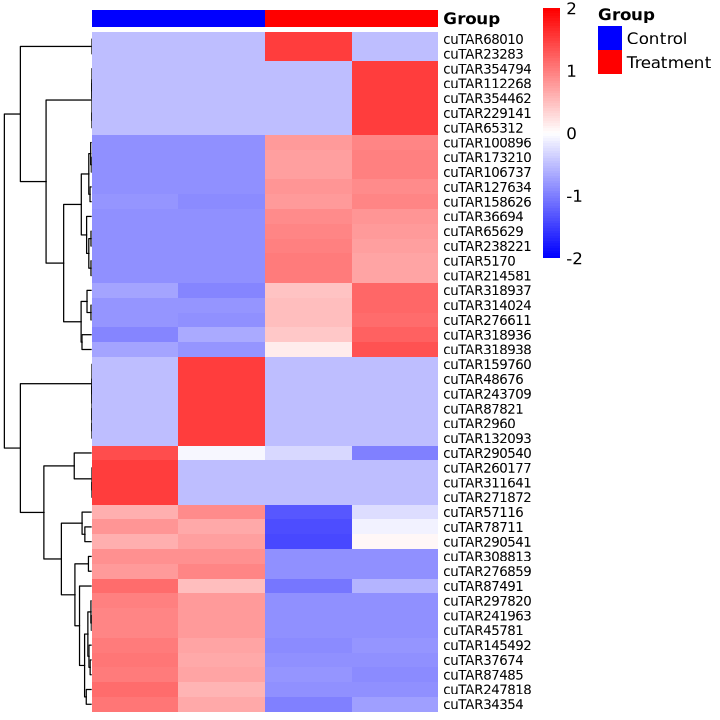

In [222]:
heatmap_data2 <- lcpm[c(topMarkers,"cuTAR78711","cuTAR276859","cuTAR290541"), ]

# Create a column annotation (for KM1 and KM2)
annotation_col <- data.frame(
  Group = rep(c("Control", "Treatment"), each = 2)  # Adjust according to your number of columns per group
)

# Set rownames of the annotation to match column names in the heatmap
rownames(annotation_col) <- colnames(heatmap_data2)


options(repr.plot.width = 6, repr.plot.height = 6)

pdf("control_vs_drug_brain.pdf",width=6, height=6)
p<-pheatmap::pheatmap(
  heatmap_data2,
  breaks = seq(-2, 2, length.out = 101),
  color = colorRampPalette(c("blue", "white", "red"))(100),
  scale = "row",
  cluster_cols = FALSE,
  border_color = "NA",
  fontsize_row = 8,
  show_colnames = FALSE,
  annotation_col = annotation_col,  # Adding the annotation column here
  annotation_colors = list(Group = c("Control" = "blue", "Treatment" = "red"))  # Customize colors for annotation
)

dev.off()

p

pdf 
  2

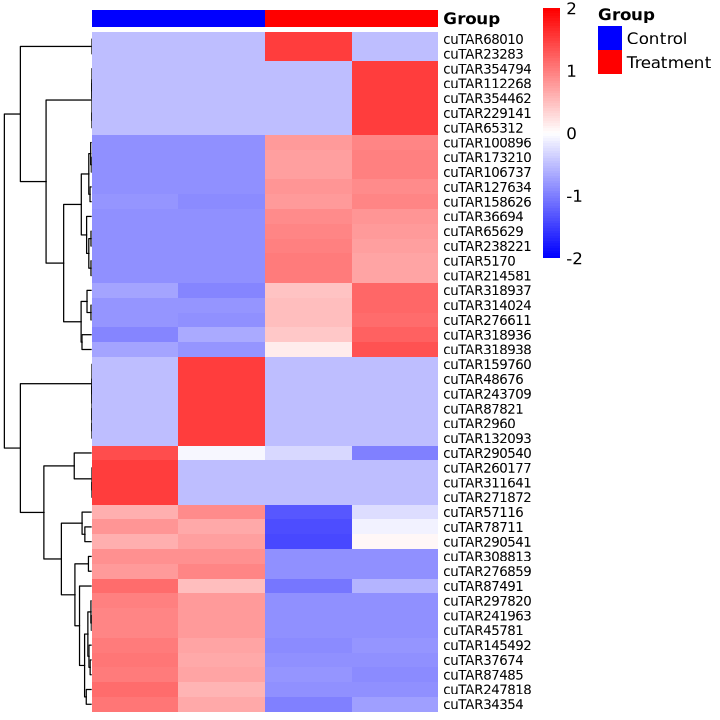

In [19]:
heatmap_data2 <- lcpm[c(topMarkers,"cuTAR78711","cuTAR276859","cuTAR290541"), ]

# Create a column annotation (for KM1 and KM2)
annotation_col <- data.frame(
  Group = rep(c("Control", "Treatment"), each = 2)  # Adjust according to your number of columns per group
)

# Set rownames of the annotation to match column names in the heatmap
rownames(annotation_col) <- colnames(heatmap_data2)


options(repr.plot.width = 6, repr.plot.height = 6)

p<-pheatmap::pheatmap(
  heatmap_data2,
  breaks = seq(-2, 2, length.out = 101),
  color = colorRampPalette(c("blue", "white", "red"))(100),
  scale = "row",
  cluster_cols = FALSE,
  border_color = "NA",
  fontsize_row = 8,
  show_colnames = FALSE,
  annotation_col = annotation_col,  # Adding the annotation column here
  annotation_colors = list(Group = c("Control" = "blue", "Treatment" = "red"))  # Customize colors for annotation
)
pdf("control_vs_drug_brain.pdf",width=6, height=6)
p
dev.off()



In [20]:
colnames(lcpm)

[1] "A_clusterControl"   "B_clusterControl"   "C_clusterTreatment"
[4] "D_clusterTreatment"

In [233]:
topMarkers

[1] "cuTAR100896" "cuTAR229141" "cuTAR127634" "cuTAR112268" "cuTAR65629" 
 [6] "cuTAR354462" "cuTAR68010"  "cuTAR354794" "cuTAR36694"  "cuTAR173210"
[11] "cuTAR23283"  "cuTAR106737" "cuTAR5170"   "cuTAR65312"  "cuTAR314024"
[16] "cuTAR238221" "cuTAR214581" "cuTAR318936" "cuTAR158626" "cuTAR318937"
[21] "cuTAR276611" "cuTAR318938" "cuTAR241963" "cuTAR260177" "cuTAR48676" 
[26] "cuTAR87821"  "cuTAR243709" "cuTAR311641" "cuTAR2960"   "cuTAR297820"
[31] "cuTAR45781"  "cuTAR247818" "cuTAR159760" "cuTAR308813" "cuTAR37674" 
[36] "cuTAR271872" "cuTAR132093" "cuTAR290540" "cuTAR34354"  "cuTAR87485" 
[41] "cuTAR145492" "cuTAR57116"  "cuTAR87491"

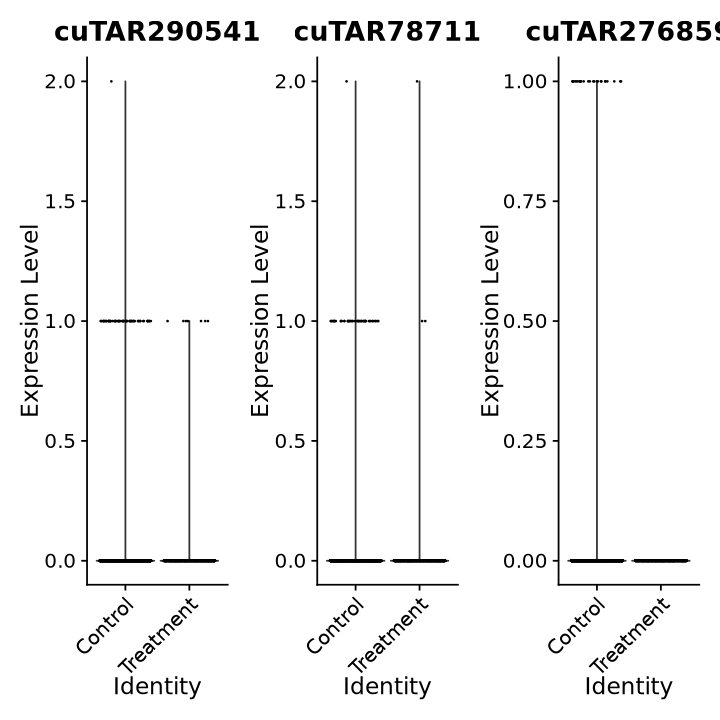

In [230]:
genes_of_interest <- c("cuTAR290541", "cuTAR78711", "cuTAR276859")
VlnPlot(so_old2, features=genes_of_interest, group.by="treatment")

In [232]:
library(Seurat)
library(ggplot2)
library(ggpubr)
library(dplyr)

# Define genes of interest
genes_of_interest <- c("cuTAR290541", "cuTAR78711", "cuTAR276859")

# Extract expression data and metadata
expr_data <- GetAssayData(so_old2, slot="data")[genes_of_interest, , drop=FALSE]
meta_data <- so_old2@meta.data

# Prepare data frame for plotting
plot_data <- as.data.frame(t(as.matrix(expr_data)))
plot_data$Treatment <- meta_data$treatment
plot_data <- plot_data %>% 
  tidyr::pivot_longer(cols=genes_of_interest, names_to="Gene", values_to="Expression")

# Calculate p-values (Wilcoxon test)
pvals <- lapply(genes_of_interest, function(gene) {
  wilcox.test(
    expr_data[gene, meta_data$treatment == "Control"],
    expr_data[gene, meta_data$treatment == "Treatment"],
    paired=FALSE
  )$p.value
})
names(pvals) <- genes_of_interest

# Create violin plots with p-values
p <- ggplot(plot_data, aes(x=Treatment, y=Expression, fill=Treatment)) +
  geom_violin(trim=TRUE) +
  scale_fill_manual(values=c("Control"="blue", "Treatment"="red")) +
  facet_wrap(~Gene, scales="free_y", ncol=3) +
  theme_minimal() +
  theme(
    strip.text = element_text(size=12),
    axis.title = element_text(size=12),
    axis.text = element_text(size=10),
    legend.position="top"
  ) +
  ylab("Expression (log-normalized)") +
  xlab("Treatment")

pvals_adjusted <- p.adjust(pvals, method="BH")
for (gene in genes_of_interest) {
  cat(sprintf("%s: FDR = %.4f\n", gene, pvals_adjusted[[gene]]))
}

# Add p-value annotations
for (i in seq_along(genes_of_interest)) {
  gene <- genes_of_interest[i]
  pval <- pvals[[gene]]
  p <- p + annotate(
    "text",
    x=1.5,
    y=max(plot_data$Expression[plot_data$Gene == gene]) * 1.1,
    label=sprintf("p = %.4f", pval),
    size=4
  )
}

# Save plot
ggsave("Violin_Plot_with_Pvalues.pdf", plot=p, width=12, height=4)

# Print p-values for reference
cat("P-values:\n")
for (gene in genes_of_interest) {
  cat(sprintf("%s: p = %.4f\n", gene, pvals[[gene]]))
}

cuTAR290541: FDR = 0.0000
cuTAR78711: FDR = 0.0000
cuTAR276859: FDR = 0.0004
P-values:
cuTAR290541: p = 0.0000
cuTAR78711: p = 0.0000
cuTAR276859: p = 0.0004
